# Assignmnet 4

Generally, a parameter selection procedure might be necessary to evaluate Probability of
Detection versus Probability of False Alarm (i.e., Pd versus Pf) in order to select a classifier
model and/or select a value for a hyperparameter for a classifier.
                                                
In this assignment we will produce an ROC plot presenting operating points of various
classifiers and their varying hyperparameters so that we can make a justifiable operating
classifier/parameter selection for the following problem.

The classification of fake news or misinformation is a very important task today. Download the
fake news dataset (https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset),
Fake.csv and True.csv files. Load the datasets into your model development framework and
examine the features to confirm that they are text in title and text columns. Set fake as 1
and true as 0. Concatenate the datasets together to produce one dataset of around 44,880
rows. Apply necessary pre-processing to extract the title column with Tf-Idf. (This assigns
numerical values to terms based on their frequency in a given document and throughout a
given collection of documents.) Use around 50 features. Make sure to include a sanity check in
the pipeline and perhaps run your favorite baseline classifier first.

```
df_true['class'] = 0; df_fake['class'] = 1
df = pd.concat([df_fake, df_true])
X = TfidfVectorizer(stop_words='english',
max_features=40).fit_transform(df['title'])
```

## 1. [70 pts]

By using three classifiers—decision tree, random forest, and neural network—and
at least 2 different hyperparameter settings for each, generate operating points and plot
them on a ROC. In particular, plot mean TPR and mean FPR, where the means are taken
from the multiple runs of cross-validations. Do not hesitate to use/modify the ROC plot code
in the module notebook if necessary. In case you do not see enough variety in Pd-Pf you
might need to work on the classifiers set and/or hyperparameters. And do not hesitate to try
hundreds, if necessary, since the ROC is just a natural scatter plot.
(Some recommended parameters and ranges: depth [3-12], number of features [3-20],
number of estimators [20-100], layer size [1-10], learning rate; and total of 10-20 Ops.)

In [1]:
# Load the datasets 
import pandas as pd

df_true = pd.read_csv('datasets/True.csv')
df_fake = pd.read_csv('datasets/Fake.csv')

In [2]:
# Inspect the dataset
print('\n\n\nTrue dataset head: \n',df_true.head(n=2))
print('\n\n\nFake dataset head: \n',df_fake.head(n=2))
print(f'\n\n\n{df_true.columns}')
print(f'\n\n\n{df_fake.columns}')

df_true['class'] = 0; df_fake['class'] = 1
df = pd.concat([df_fake, df_true])
print(f'\n\n\nThe columns of the final dataset are: {df.columns}')
print(f'dataframe has {len(df)} samples.')




True dataset head: 
                                                title  \
0  As U.S. budget fight looms, Republicans flip t...   
1  U.S. military to accept transgender recruits o...   

                                                text       subject  \
0  WASHINGTON (Reuters) - The head of a conservat...  politicsNews   
1  WASHINGTON (Reuters) - Transgender people will...  politicsNews   

                 date  
0  December 31, 2017   
1  December 29, 2017   



Fake dataset head: 
                                                title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   

                date  
0  December 31, 2017  
1  December 31, 2017  



Index(['title', 'text', 'subject', 'date'], dtype='object')



Ind

### Split the data into training and testing, and try a 

Per the assignment prompt do a sanity-- in this case check that we have the correct number of samples, approximately 44,000

In [3]:
# Transform the titles into a vector
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split

MAX_FEAUTRES = 50
X = TfidfVectorizer(stop_words='english', max_features=MAX_FEAUTRES).fit_transform(df['title'])
y = df['class']
print(X.shape, y.shape)
print(f'Unique values of target vector: {y.unique()}')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

(44898, 50) (44898,)
Unique values of target vector: [1 0]


### Sanity Check I have What I think I need

In [4]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
test_model = LogisticRegression()
test_model.fit(X_train, y_train)
y_pred = test_model.predict(X_test)
print(f'Accuracy of LogisticRegression with no tuning: {accuracy_score(y_test,y_pred)}')

Accuracy of LogisticRegression with no tuning: 0.815924276169265


### Setup paramters across several classifiers

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, HalvingRandomSearchCV, train_test_split
from sklearn.linear_model import Perceptron
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

import numpy as np


clfs = {
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    # 'neural_network': Perceptron(random_state=42)
}
param_dict = {
    'halving_search': {
        'decision_tree': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'splitter': ['best', 'random'],
            'max_depth': [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37],
            'ccp_alpha': np.linspace(0.01, 5, 10),
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'random_forest': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37],
            'ccp_alpha': np.linspace(0.01, 5, 10),
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'neural_network': {
            'random_state': [None, 42],
            'penalty': ['l2', 'l1', 'elasticnet', None],
            'eta0': np.linspace(.5, 10, 100),
            'early_stopping': [True, False],
            'validation_fraction': np.linspace(0, 1, 50),
            'l1_ratio': np.linspace(0.01, 0.3, 50)
        }
    },
    'grid_search': {
        'decision_tree': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'splitter': ['best', 'random'],
            'max_depth': [2, 3, 5, 7, 11, 13],
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'random_forest': {
            'criterion':['gini', 'entropy', 'log_loss'],
            'max_features': ['sqrt', 'log2', None],
            'max_depth': [2, 3, 5, 7, 11, 13],
            'random_state': [None, 42],
            'min_samples_leaf': MAX_FEAUTRES*[.01, .05, .1, .15, .2, 1/MAX_FEAUTRES],
        },
        'neural_network': {
            'random_state': [None, 42],
            'penalty': ['l2', 'l1', 'elasticnet', None],
            'eta0': np.linspace(.5, 5, 10),
            'early_stopping': [True, False],
            'validation_fraction': np.linspace(0.01, 1, 5)
        }
    }
}

### Get the best hyperparameters for each model

Note: after testing with GridSeach, and the amount of params I put in, the timespace was untenable.

In [6]:
bests = {}
for k in clfs.keys():
    print(f'\n\n\nrunning halving random search for {k}')
    hs = HalvingRandomSearchCV(clfs[k], param_dict['halving_search'][k], cv=5, scoring='f1_weighted', n_jobs=8, verbose=1)
    hs.fit(X_train, y_train)
    # print(f'cv_results_: {hs.cv_results_}')
    bests[k+'__HalvingSearch'] = { 
                'best_model': hs.best_estimator_,
                'best_accuracy': hs.best_estimator_.score(X_test, y_test),
                'best_params': hs.best_params_,
                'best_score': hs.best_score_
            }
    # print(f'\n\n\nrunning grid search for {k}')
    # gs = GridSearchCV(clfs[k], param_dict['grid_search'][k], cv=5, scoring='accuracy', n_jobs=8, verbose=1)
    # gs.fit(X_train, y_train)
    # bests[k+'__GridSearch'] = { 
    #             'best_model': gs.best_estimator_,
    #             'best_accuracy': gs.best_estimator_.score(X_test, y_test),
    #             'best_params': gs.best_params_,
    #             'best_score': gs.best_score_
    #         }
    




running halving random search for decision_tree
n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 20
max_resources_: 35918
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1795
n_resources: 20
Fitting 5 folds for each of 1795 candidates, totalling 8975 fits
----------
iter: 1
n_candidates: 599
n_resources: 60
Fitting 5 folds for each of 599 candidates, totalling 2995 fits
----------
iter: 2
n_candidates: 200
n_resources: 180
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
----------
iter: 3
n_candidates: 67
n_resources: 540
Fitting 5 folds for each of 67 candidates, totalling 335 fits
----------
iter: 4
n_candidates: 23
n_resources: 1620
Fitting 5 folds for each of 23 candidates, totalling 115 fits
----------
iter: 5
n_candidates: 8
n_resources: 4860
Fitting 5 folds for each of 8 candidates, totalling 40 fits
----------
iter: 6
n_candidates: 3
n_resources: 14580
Fitting 5 folds for each of 3 candidates, totallin

### For my own sake print the best parts of each model

In [7]:
for k_clf, clf_scores in bests.items():
    print(f'For {str(k_clf).replace('__HalvingSearch',' with halving random search').replace('__GridSearch',' with grid search')} achieved')
    for k, v in clf_scores.items():
        print(f'\t\t{k}: {v}')
    print()
    print()
        

For decision_tree with halving random search achieved
		best_model: DecisionTreeClassifier(ccp_alpha=np.float64(0.01), criterion='entropy',
                       max_depth=19, min_samples_leaf=0.01, random_state=42)
		best_accuracy: 0.7625835189309577
		best_params: {'splitter': 'best', 'random_state': 42, 'min_samples_leaf': 0.01, 'max_features': None, 'max_depth': 19, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.01)}
		best_score: 0.7454269146353658


For random_forest with halving random search achieved
		best_model: RandomForestClassifier(ccp_alpha=np.float64(0.01), criterion='entropy',
                       max_depth=31, max_features='log2', min_samples_leaf=0.01,
                       random_state=42)
		best_accuracy: 0.7848552338530067
		best_params: {'random_state': 42, 'min_samples_leaf': 0.01, 'max_features': 'log2', 'max_depth': 31, 'criterion': 'entropy', 'ccp_alpha': np.float64(0.01)}
		best_score: 0.7756021468206796




In [8]:
# Display OP
def annot(opi, _x, _y):
    plt.annotate(f"OP{opi}", xy=(_x, _y), xytext=(.90*_x+.1, .80*_y), arrowprops=dict(facecolor='lightgray', shrink=1))

def plotter(TPR, FPR):
    fpr = [0.]+list(FPR)+[1.]; tpr = [0.]+list(TPR)+[1.]

    # Plot
    fig, ax = plt.subplots(dpi=72)
    plt.plot(fpr, tpr, ':', label='ROC')
    plt.scatter(FPR, TPR, 50, color='red', marker='o', label='operating points')
    plt.plot([0, 1], [0, 1], linestyle='--', color=(0.6, 0.6, 0.6), label='coin flip')
    
    # Annotate certain operating points
    annot(1, fpr[1], tpr[1])
    annot(2, fpr[4], tpr[4])
    annot(3, fpr[8], tpr[8])
    annot(4, fpr[9], tpr[9])
    
    # Labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

decision_tree
y_test (8980,) y_pred (8980,) X_train (35918, 50) X_test (8980, 50) y_train (35918,) y_test (8980,)
random_forest
y_test (8980,) y_pred (8980,) X_train (35918, 50) X_test (8980, 50) y_train (35918,) y_test (8980,)


/tmp/ipykernel_7021/1857444448.py:31: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


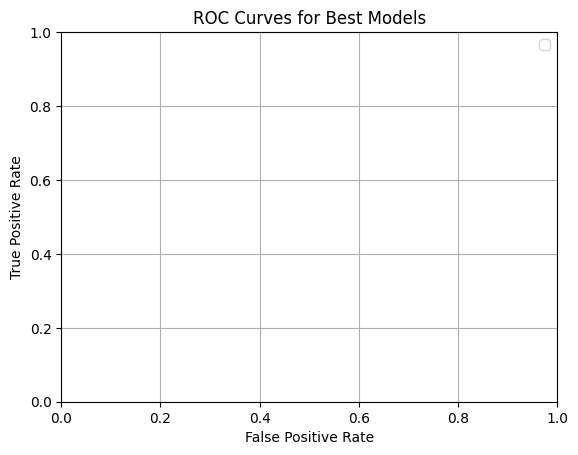

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import auc, confusion_matrix, RocCurveDisplay, roc_curve

roc_plots = []
for k_clf, clf_scores in bests.items():
    FPR, TPR = [], []
    model_name = k_clf.replace('__HalvingSearch','').replace('__GridSearch','')
    print(model_name)
    # Get probabiliites for predictions
    # Perceptron doesn't have predict_proba, but the other two do.  Account for that here
    if hasattr(clf_scores['best_model'], 'predict_proba'):
        y_pred = clf_scores['best_model'].predict_proba(X_test)
    else:
        y_pred = clf_scores['best_model'].predict(X_test)
    
    y_pred = clf_scores['best_model'].predict(X_test)
    # tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # TPR += [tp/(tp+fn)]  # Pd
    # FPR += [fp/(fp+tn)]  # Pf
    # print(f'{model_name}: len(TPR)={len(TPR)}\tlen(FPR)={len(FPR)}\tlen(X_Test)={len(X_test)}')
    # plotter(TPR, FPR)
    # roc_plots.append(RocCurveDisplay(tpr=TPR, fpr=FPR).plot())
    # print('y_test',y_test.shape, 'y_pred', y_pred.shape, 'X_train', X_train.shape, 'X_test', X_test.shape, 'y_train', y_train.shape, 'y_test', y_test.shape)
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name=model_name)
    # RocCurveDisplay(fpr=fpr, tpr=tpr).plot(ax=plt.gca(), name=model_name)

plt.title("ROC Curves for Best Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

In [ ]:
fig, axs = plt.subplots(1, len(roc_plots), figsize=(12, 8))
for i in range(len(roc_plots)):
    axs[0, i].plot(roc_plots[i])
    # roc_plots[i].plot(ax=axs[0, i])